In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString
import matplotlib.pyplot as plt

In [2]:
# 1. Načti data
df = pd.read_excel('../data/czech/data_czech.xlsx')

# 2. Ulož název krajů ze sloupce a nastav index
df = df.rename(columns={'University ↓ / Student →': 'origin'})
df = df.set_index('origin')

# 3. Očisti názvy (pro jistotu, kvůli shodě)
df.index = df.index.str.strip()
df.columns = df.columns.str.strip()

# 4. Pro každou krajskou kombinaci: pokud je řádek == sloupec → nastav 0
for region in df.index:
    if region in df.columns:
        df.at[region, region] = 0

# 5. Výstup pro kontrolu
print(df)

                      Hlavní město Praha  Středočeský kraj  Jihočeský kraj  \
origin                                                                       
Hlavní město Praha                     0             24305            5838   
Jihomoravský kraj                    986              1432            1195   
Jihočeský kraj                       572              1268               0   
Královéhradecký kraj                 366               978             143   
Liberecký kraj                       324              1026              37   
Moravskoslezský kraj                 232               296              99   
Olomoucký kraj                       640               748             212   
Pardubický kraj                      262               962              76   
Plzeňský kraj                        657              1243            1229   
Středočeský kraj                     548                 0             141   
Kraj Vysočina                         40                91      

In [3]:
# Příchozí studenti do každého kraje
prichozi = df.sum(axis=1).rename('prichozi')

print(prichozi)


origin
Hlavní město Praha      70060
Jihomoravský kraj       27625
Jihočeský kraj           4970
Královéhradecký kraj     5047
Liberecký kraj           3108
Moravskoslezský kraj     6125
Olomoucký kraj          14657
Pardubický kraj          4220
Plzeňský kraj            6279
Středočeský kraj         1754
Kraj Vysočina             690
Zlínský kraj             4152
Ústecký kraj             2666
Name: prichozi, dtype: int64


In [4]:
# Odchozí studenti z každého kraje
odchozi = df.sum(axis=0).rename('odchozi')

print(odchozi)


Hlavní město Praha       5169
Středočeský kraj        33302
Jihočeský kraj           9206
Plzeňský kraj            6198
Karlovarský kraj         5196
Ústecký kraj            10637
Liberecký kraj           6707
Královéhradecký kraj    10013
Pardubický kraj         10176
Kraj Vysočina           11552
Jihomoravský kraj        8573
Olomoucký kraj           9551
Zlínský kraj            11606
Moravskoslezský kraj    13467
Name: odchozi, dtype: int64


In [5]:
# Load spatial regions
gdf = gpd.read_file('../data/czech/regions.gpkg')

# Keep only necessary columns and compute centroids
gdf = gdf[['nazev', 'geometry']]

# Compute centroids
gdf['centroid'] = gdf.geometry.centroid

# Show the result
gdf.head()

,nazev,geometry,centroid
0,Hlavní město Praha,"MULTIPOLYGON (((4644153.668 3017220.732, 46441...",POINT (4640553.289 3004667.586)
1,Jihočeský kraj,"MULTIPOLYGON (((4614559.886 2946839.972, 46145...",POINT (4644571.676 2896376.941)
2,Plzeňský kraj,"MULTIPOLYGON (((4557165.672 3003874.933, 45571...",POINT (4554357.223 2947867.821)
3,Karlovarský kraj,"MULTIPOLYGON (((4521107.248 3042368.860, 45211...",POINT (4517635.093 3010561.894)
4,Liberecký kraj,"MULTIPOLYGON (((4672911.633 3113397.259, 46729...",POINT (4673801.100 3077989.990)


In [6]:
# Převod na DataFrame a zajištění správného indexu
df_prichozi = prichozi.reset_index().set_index('origin')
df_odchozi = odchozi.reset_index().set_index('index')


In [7]:
# Nejdřív merge příchozích
gdf = gdf.merge(df_prichozi, left_on='nazev', right_index=True, how='left')

# Potom merge odchozích
gdf = gdf.merge(df_odchozi, left_on='nazev', right_index=True, how='left')

# Vyplníme případné NaNy nulou
gdf[['prichozi', 'odchozi']] = gdf[['prichozi', 'odchozi']].fillna(0).astype(int)
gdf

,nazev,geometry,centroid,prichozi,odchozi
0,Hlavní město Praha,"MULTIPOLYGON (((4644153.668 3017220.732, 46441...",POINT (4640553.289 3004667.586),70060,5169
1,Jihočeský kraj,"MULTIPOLYGON (((4614559.886 2946839.972, 46145...",POINT (4644571.676 2896376.941),4970,9206
2,Plzeňský kraj,"MULTIPOLYGON (((4557165.672 3003874.933, 45571...",POINT (4554357.223 2947867.821),6279,6198
3,Karlovarský kraj,"MULTIPOLYGON (((4521107.248 3042368.860, 45211...",POINT (4517635.093 3010561.894),0,5196
4,Liberecký kraj,"MULTIPOLYGON (((4672911.633 3113397.259, 46729...",POINT (4673801.100 3077989.990),3108,6707
5,Pardubický kraj,"MULTIPOLYGON (((4732869.806 3022958.327, 47329...",POINT (4765284.801 2995306.439),4220,10176
6,Kraj Vysočina,"MULTIPOLYGON (((4715791.911 2986533.031, 47157...",POINT (4732189.380 2938122.688),690,11552
7,Jihomoravský kraj,"MULTIPOLYGON (((4793943.251 2967571.590, 47939...",POINT (4805095.894 2907028.912),27625,8573
8,Olomoucký kraj,"MULTIPOLYGON (((4809079.189 3059724.075, 48090...",POINT (4838155.923 2987947.406),14657,9551
9,Moravskoslezský kraj,"MULTIPOLYGON (((4867703.925 3049792.801, 48677...",POINT (4894160.179 2998762.522),6125,13467


In [8]:
gdf['celkem'] = gdf['prichozi'] + gdf['odchozi']
gdf

,nazev,geometry,centroid,prichozi,odchozi,celkem
0,Hlavní město Praha,"MULTIPOLYGON (((4644153.668 3017220.732, 46441...",POINT (4640553.289 3004667.586),70060,5169,75229
1,Jihočeský kraj,"MULTIPOLYGON (((4614559.886 2946839.972, 46145...",POINT (4644571.676 2896376.941),4970,9206,14176
2,Plzeňský kraj,"MULTIPOLYGON (((4557165.672 3003874.933, 45571...",POINT (4554357.223 2947867.821),6279,6198,12477
3,Karlovarský kraj,"MULTIPOLYGON (((4521107.248 3042368.860, 45211...",POINT (4517635.093 3010561.894),0,5196,5196
4,Liberecký kraj,"MULTIPOLYGON (((4672911.633 3113397.259, 46729...",POINT (4673801.100 3077989.990),3108,6707,9815
5,Pardubický kraj,"MULTIPOLYGON (((4732869.806 3022958.327, 47329...",POINT (4765284.801 2995306.439),4220,10176,14396
6,Kraj Vysočina,"MULTIPOLYGON (((4715791.911 2986533.031, 47157...",POINT (4732189.380 2938122.688),690,11552,12242
7,Jihomoravský kraj,"MULTIPOLYGON (((4793943.251 2967571.590, 47939...",POINT (4805095.894 2907028.912),27625,8573,36198
8,Olomoucký kraj,"MULTIPOLYGON (((4809079.189 3059724.075, 48090...",POINT (4838155.923 2987947.406),14657,9551,24208
9,Moravskoslezský kraj,"MULTIPOLYGON (((4867703.925 3049792.801, 48677...",POINT (4894160.179 2998762.522),6125,13467,19592


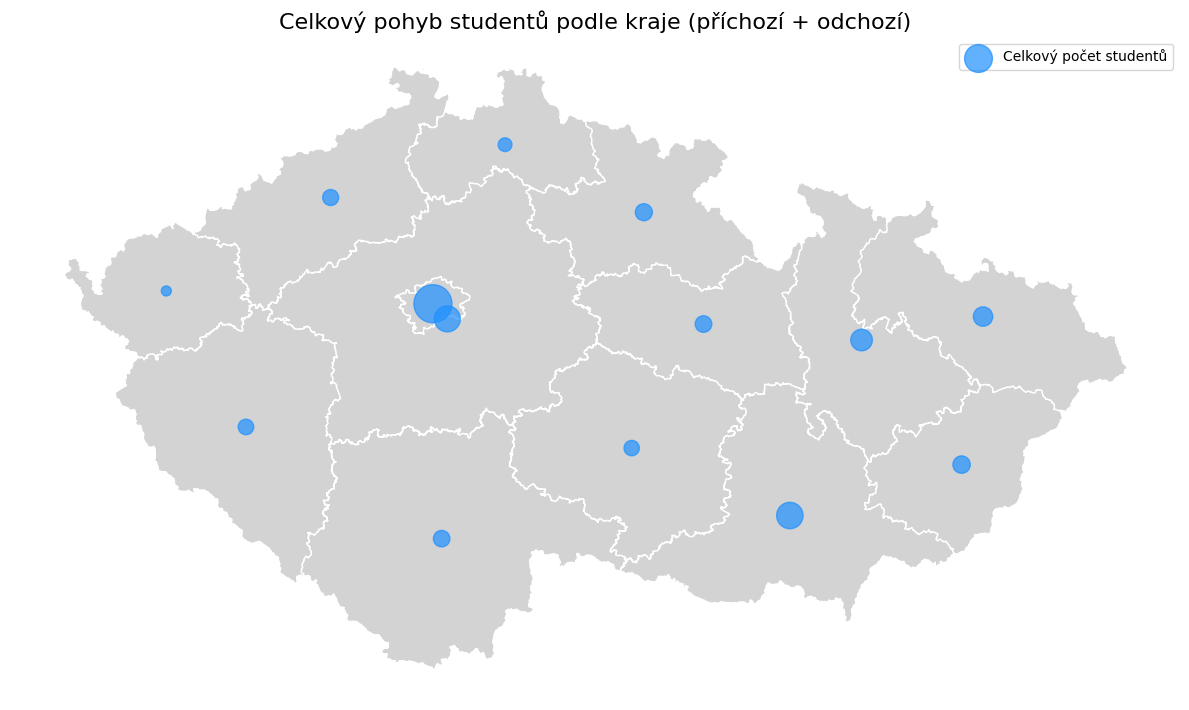

In [11]:
import matplotlib.pyplot as plt

# 1. Nastavení figury a os
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

# 2. Vykreslení polygonů (krajů)
gdf.plot(ax=ax, color='lightgrey', edgecolor='white')

# 3. Vykreslení centroidů jako bodů, velikost podle 'celkem'
gdf.set_geometry('centroid').plot(
    ax=ax,
    markersize=gdf['celkem'] / 100,  # škáluj podle potřeby (větší jmenovatel = menší kruhy)
    color='dodgerblue',
    alpha=0.7,
    label='Celkový počet studentů'
)

# 4. Titulek, legenda a vzhled
ax.set_title("Celkový pohyb studentů podle kraje (příchozí + odchozí)", fontsize=16)
ax.axis('off')
ax.legend()
plt.tight_layout()
plt.show()

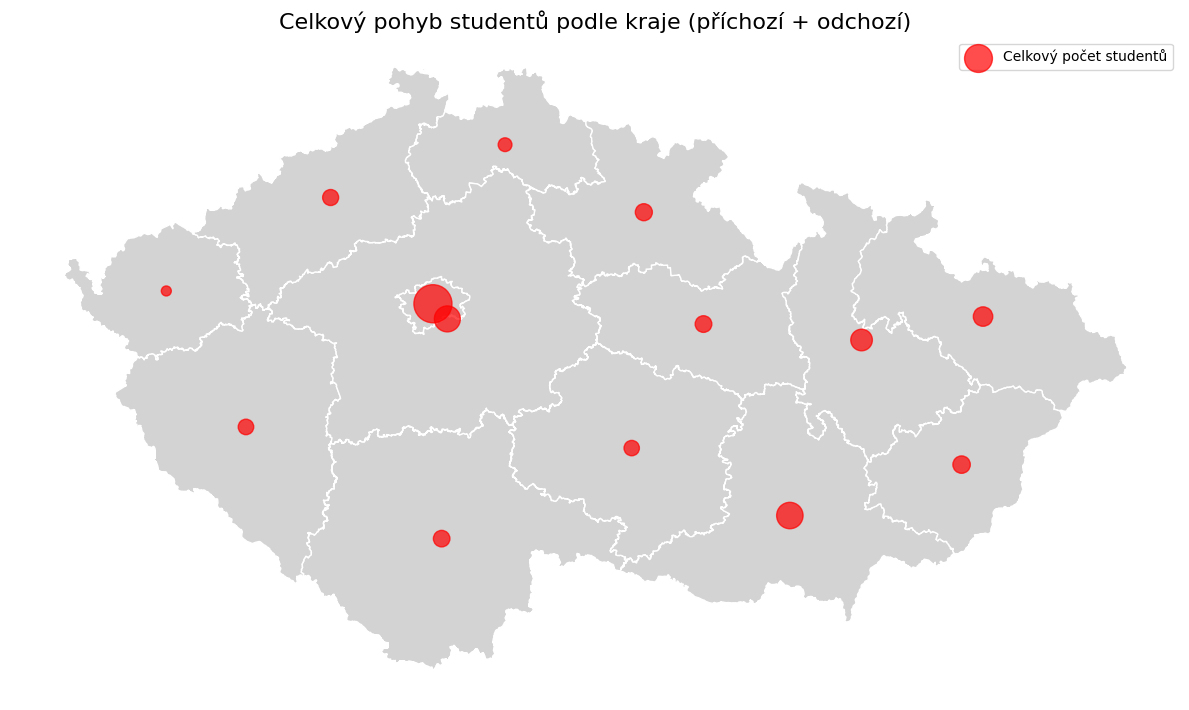

In [14]:
import matplotlib.pyplot as plt

# 1. Nastavení figury a os
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

# 2. Vykreslení krajských polygonů
gdf.plot(ax=ax, color='lightgrey', edgecolor='white')

# 3. Vykreslení centroidů jako bodů, velikost podle 'celkem', červeně
gdf.set_geometry('centroid').plot(
    ax=ax,
    markersize=gdf['celkem'] / 100,  # Škálování podle celkového počtu studentů
    color='red',                    # Barva bodů (centroidů)
    alpha=0.7,                      # Průhlednost
    label='Celkový počet studentů'
)

# 4. Titulek, legenda a vzhled
ax.set_title("Celkový pohyb studentů podle kraje (příchozí + odchozí)", fontsize=16)
ax.axis('off')
ax.legend()
plt.tight_layout()
plt.show()


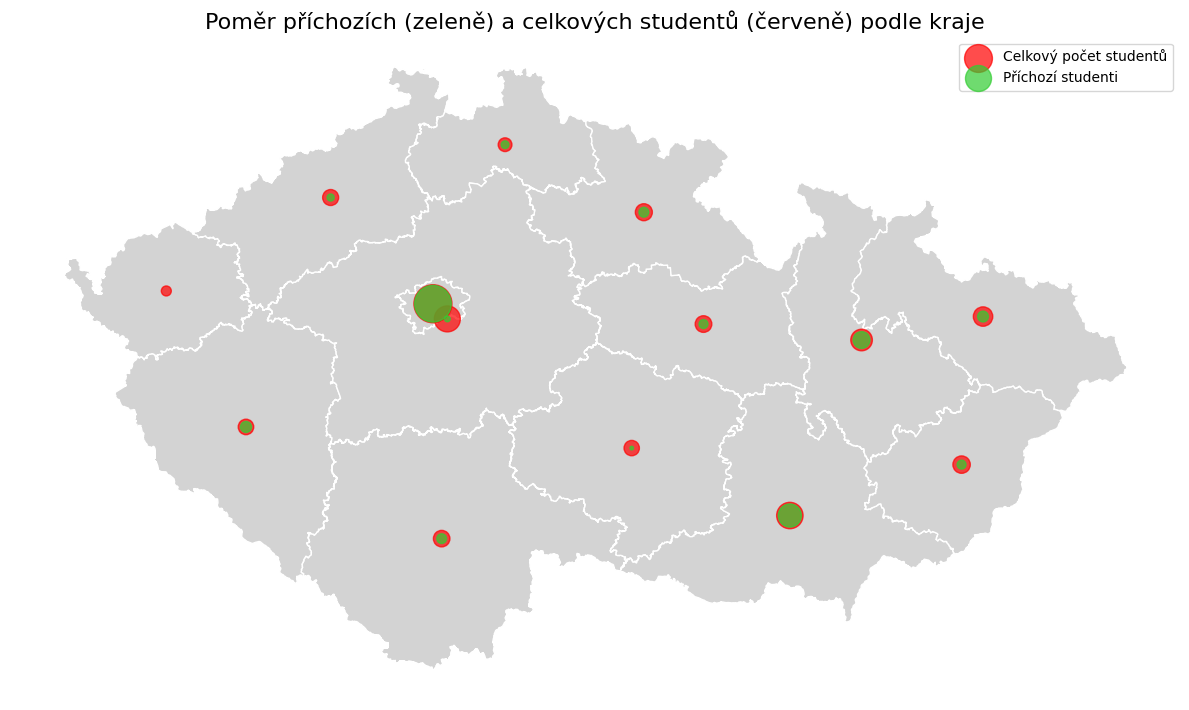

In [15]:
import matplotlib.pyplot as plt

# 1. Nastavení figury a os
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

# 2. Vykreslení krajských polygonů
gdf.plot(ax=ax, color='lightgrey', edgecolor='white')

# 3. Vykreslení centroidů pro celkový počet studentů (červeně)
gdf.set_geometry('centroid').plot(
    ax=ax,
    markersize=gdf['celkem'] / 100,  # Škálování podle celkového počtu studentů
    color='red',                    # Barva bodů (centroidů)
    alpha=0.7,                      # Průhlednost
    label='Celkový počet studentů'
)

# 4. Vykreslení centroidů pro příchozí studenty (zeleně)
gdf.set_geometry('centroid').plot(
    ax=ax,
    markersize=gdf['prichozi'] / 100,  # Škálování podle počtu příchozích studentů
    color='limegreen',                 # Barva bodů pro příchozí
    alpha=0.7,                         # Průhlednost
    label='Příchozí studenti'
)

# 5. Titulek, legenda a vzhled
ax.set_title("Poměr příchozích (zeleně) a celkových studentů (červeně) podle kraje", fontsize=16)
ax.axis('off')
ax.legend()
plt.tight_layout()
plt.show()
